### All necessary libraries imports

In [4]:
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)

## Loading CNN Dataset

In [5]:
# Define the path to the folder containing the image dataset
data_dir = 'cnn_dataset'
# data_dir = '/kaggle/input/cnn-dataset'

# Define the transforms to be applied to the images
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the entire dataset using the ImageFolder class
full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms['train'])

# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

BATCH_SIZE = 32

# Create dataloaders for each dataset
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=30),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=30),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=30)
}

# Find the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the tensors to the found device
for x in ['train', 'val', 'test']:
    for inputs, labels in dataloaders[x]:
        inputs = inputs.to(device)
        labels = labels.to(device)

# Print the size of each dataset
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val', 'test']}
print(dataset_sizes)


{'train': 21000, 'val': 6000, 'test': 3000}


### Model Train, Validation, Test and Plot functions

In [6]:
def train(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (train_images, train_labels) in enumerate(train_loader):
        train_images = train_images.to(device)
        train_labels = train_labels.to(device)
        optimizer.zero_grad()
        train_outputs = model(train_images)
        train_loss = criterion(train_outputs, train_labels)
        train_loss.backward()
        optimizer.step()
        running_loss += train_loss.item()
        _, predicted = train_outputs.max(1)
        total += train_labels.size(0)
        correct += predicted.eq(train_labels).sum().item()
    average_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return average_loss, train_accuracy


def validate(model, criterion, val_loader, device):
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_images)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item() * val_images.size(0)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            total_val += val_labels.size(0)
    val_acc = 100.0 * val_correct / total_val
    val_loss = val_loss / total_val
    return val_acc, val_loss

def test(model, criterion, test_loader, model_path, device):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    test_loss = 0.0
    test_correct = 0
    total_test = 0
    with torch.no_grad():
        for test_images, test_labels in test_loader:
            test_images = test_images.to(device)
            test_labels = test_labels.to(device)
            test_outputs = model(test_images)
            loss = criterion(test_outputs, test_labels)
            test_loss += loss.item() * test_images.size(0)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_correct += (test_predicted == test_labels).sum().item()
            total_test += test_labels.size(0)
    test_acc = 100.0 * test_correct / total_test
    test_loss = test_loss / total_test
    return test_acc, test_loss

def plot_fn(train_loss,val_loss,train_acc,val_acc):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    # Plot the training and test loss on the same plot
    ax2.plot(train_loss, label='Training Loss')
    ax2.plot(val_loss, label='Validation Loss')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # Plot the training and test accuracy on the same plot
    ax1.plot(train_acc, label='Training Accuracy')
    ax1.plot(val_acc, label='Validattion Accuracy')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Display the plot
    plt.show()

## Building VGG-13 Architecture

In [7]:
import torch.nn as nn

class ConvNetB(nn.Module):
    def __init__(self):
        super(ConvNetB, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 3)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


## Code block which calls model training, validation, testing and plotting functions. 

ConvNetB(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

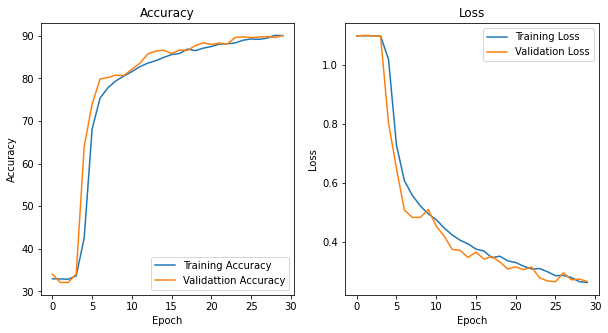

Test Loss: 0.28 -Test Accuracy: 89.77%


In [8]:
########################################################################################################
model = ConvNetB()
print(model)

# set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define the model and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# set up training and validation dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=30)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=30)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=30)

# train the model
num_epochs = 30
best_val_acc = 0.0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model.to(device), criterion, optimizer, train_loader, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    val_acc, val_loss = validate(model.to(device), criterion, val_loader, device)
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}--------------------------------------------------")
    print(f"Train Loss: {train_loss:.2f} - Validation Loss: {val_loss:.2f}")
    print(f"Train Accuracy: {train_acc:.2f}% - Validation Accuracy: {val_acc:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model4.pt')

plot_fn(train_losses,val_losses,train_accs,val_accs)


# test the model on the test set
model_path = 'best_model4.pt'
test_acc, test_loss = test(model.to(device), criterion, test_loader, model_path, device)
print(f"Test Loss: {test_loss:.2f} -Test Accuracy: {test_acc:.2f}%")

## VGG-13 Model performance on the CNN dataset

### Loss: 0.28
### Accuracy: 89.77%

## Contribution of Team Members

| Team Member | Assignment Part | Contribution (%) |
| --- | --- | --- |
| msikha | part-I step2 1, 2, 4 and part-II setups | 50% |
| zemingzh| part-I step 3 and part-II optimization methods | 50% |
